# Aprendizaje Automático

## Práctica 4: Regresión Logística y Regularización

En esta práctica vamos a implementar la regresión logística desde cero, realizando el aprendizaje con el descenso por gradiente. Veremos también el efecto de las características polinomiales y aplicaremos regularización para resolver el sobreaprendizaje.

### Índice de la práctica

- [Lectura de datos](#Lectura-de-datos)
- [Regresión logística](#regresion)
- [Regresión logística con regularización](#regularizacion)

Comenzamos importando todas las librerías que vamos a utilizar durante la práctica.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
from matplotlib.colors import ListedColormap


# Helper function to test the correctness of the solutions
def test_nb(var, val, msg=""):
    if var == val:
        print("✔️ Test passed.")
    else:
        print("❌ Test failed. " + msg)
        raise AssertionError(msg)

%matplotlib inline

### Lectura de datos

En primer lugar, vamos a comenzar leyendo los datos y visualizándolos para poder comprender mejor el problema al que nos enfrentamos.

Comenzaremos definiendo una función que lee un archivo que contiene los datos de entrenamiento. La función recibe como parámetro de entrada el nombre del fichero que contiene los datos de entrenamiento así como el símbolo utilizado para separar los valores de las variables del problema (delimitador). Además de leer los datos y devolver un array que los contenga, la función muestra por pantalla las dimensiones del dataset así como los 5 primeros ejemplos del mismo.

Dentro de esta función tendrás que hacer uso de la función `loadtxt` de numpy con los parámetros apropiados.

In [2]:
def read_data(file_name, delimiter):
    data = np.loadtxt(file_name, delimiter=delimiter)
    print('Dimensiones de los datos: ', data.shape)
    print(data[0:5, :])
    return data

Utiliza la función implementada para leer el fichero `admisions.txt`.

Los datos contenidos en este fichero corresponden a un problema en el que se debe **predecir si un estudiante es admitido en una universidad o no**. El acceso a la universidad viene determinado por la nota obtenida por los estudiantes en dos exámenes realizados previamente. El archivo contiene el histórico de las notas obtenidas en ambos exámenes (variables de entrada) para 100 alumnos así como si han ingresado en la universidad o no (variable de salida).


In [3]:
# Guarda los datos en la variable data
data = read_data('admisions.txt',',')


Dimensiones de los datos:  (100, 3)
[[34.62365962 78.02469282  0.        ]
 [30.28671077 43.89499752  0.        ]
 [35.84740877 72.90219803  0.        ]
 [60.18259939 86.3085521   1.        ]
 [79.03273605 75.34437644  1.        ]]


A continuación, vamos a crear las matrices con los datos de entrada ($X$) y de salida ($y$) para poder realizar el aprendizaje de los parámetros de la regresión logística ($\theta$). Recuerda que la primera columna de los datos de entrada debe estar compuesta por unos para multiplicar al término independiente de la regresión logística ($\theta_0$). Por tanto, la variable $X$ estará compuesta por tantas columnas como variables de entrada más una (la de unos). La variable $y$ debe contener la información de la variable respuesta, es decir, si los alumnos han sido admitidos o no.

In [4]:
# Crea las variables X e y
X_aux = data[:,:-1]
X = np.column_stack([np.ones([X_aux.shape[0],1]), X_aux])
y = data[:,-1].reshape(-1,1)


In [5]:
test_nb(list(X[0,:]), [1.0, 34.623659624516968, 78.0246928153624], 'X no está bien formada')
test_nb(list(y[:5, 0]), [0.0, 0.0, 0.0, 1.0, 1.0], 'y no está bien formada')

✔️ Test passed.
✔️ Test passed.


A continuación, vamos a definir una función que muestre los datos de entrenamiento gráficamente.

Esta función va a ser genérica para problemas de clasificación de dos clases por lo que
* La clase negativa va a ser la que tenga asociada la etiqueta 0
* La clase positiva va a ser la que tenga asociada la etiqueta 1

La función recibe como parámetros de entrada los datos (variables $X$ e $y$), las etiquetas de los ejes x e y (dos variables de entrada) así como la etiqueta para los datos de la clase positiva y de la clase negativa (para que se muestren en la leyenda de la figura).

In [6]:

def plot_data(X, y, x_label, y_label, pos_class_label, neg_class_label, ax=None):
    # Si no se pasa un manejador de una figura se crea una
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    
    # La variable neg_class_mask debe ser un array de booleanos compuesto por tantos elementos como ejemplos
        # Los ejemplos de la clase 0 deben tener True en su correspondiente posición del array de booleanos y False en el resto
        # la máscara debe ser un array, asegúrate de ello con .ravel()
    neg_class_mask = (y == False).ravel()
    # La variable pos_class_mask debe ser un array de booleanos compuesto por tantos elementos como ejemplos
        # Los ejemplos de la clase 1 deben tener True en su correspondiente posición del array de booleanos y False en el resto
        # la máscara debe ser un array, asegúrate de ello con .ravel()
    pos_class_mask = (y==True).ravel()
    # A veces querremos representar puntos a los que hemos añadido la columna de 1s y otras veces no
    # En caso detener la columna de unos, la quitaremos para dibujar
    if X.shape[1] == 3:
        X = X[:, 1:] 
# Muestra la nube de puntos: + azules para la clase 1 y círculos rojos para la clase 0 
    # Utiliza los vectores neg_class_mask y pos_class_mask como máscara para pintar solo los datos correspondientes a la clase en cuestión
        # Utiliza marker= para establecer el marcador
        # Utiliza c= para establecer el color
        # Utiliza label= para establecer la etiqueta de los datos
    # Debes utilizar la variable ax y utilizar su método scatter
    # positivos (clase 1)
    ax.scatter(X[pos_class_mask, 0], X[pos_class_mask, 1],
           marker='x', s=30, c='b', label=pos_class_label)

    # negativos (clase 0)
    ax.scatter(X[neg_class_mask, 0], X[neg_class_mask, 1],
           marker='o', s=30, c='r', label=neg_class_label)

    # Establecemos las etiquetas de los ejes
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Añadimos la leyenda
    ax.legend(frameon=True, fancybox=True, loc='upper right')

    return ax

Utiliza ahora la función definida para visualizar los datos para mostrar los datos recién leídos. Los alumnos admitidos se codifican con 1 y los no admitidos con 0. El resultado debe ser similar a la siguiente figura.

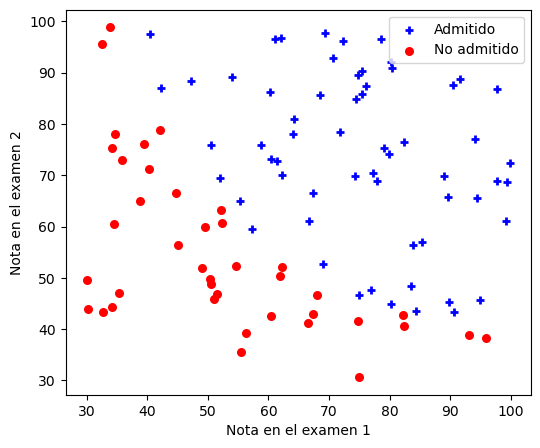

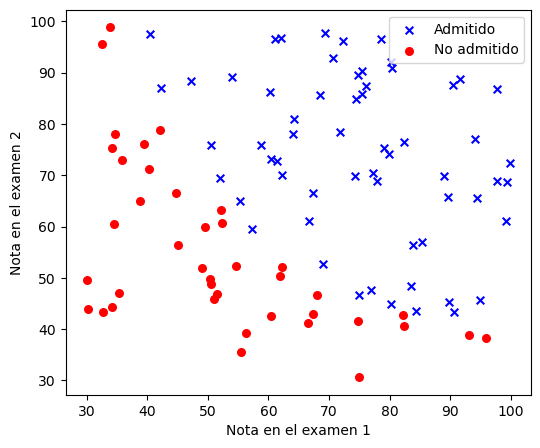

In [7]:
ax = plot_data(X, y, x_label='Nota en el examen 1', y_label='Nota en el examen 2', pos_class_label='Admitido', neg_class_label='No admitido')
plt.show()

### Regresión logística <a id="regresion"></a>

#### Modelo de regresión logística

Ahora vamos a implementar el modelo de la regresión logística. Recuerda que es el mismo que el de la regresión lineal, pero aplicando una función sigmoide sobre el resultado para conseguir una función convexa y, de esta forma, poder aplicar el descenso por gradiente para minimizar la función de coste.

Concretamente, la **hipótesis de la regresión logística** es
 $$ h_{\theta}(x) = g(\theta^{T}x).$$

donde **$g$ es la función sigmoide definida como**
 $$ g(z)=\frac{1}{1+e^{−z}}. $$

Para implementar el modelo, vamos a crear una función que permita calcular la sigmoide, $g(z)$, sobre un dato $z$. Este dato puede ser un array de valores.

> **Nota:** La función `exp` de numpy (pasando un valor `z` como parámetro de entrada) sirve para calular $e^{z}$.

In [8]:
def sigmoid(z):
    return 1 /(1+np.exp(-z))

Recuerda que:
* Para el valor 0.0 el resultado debe ser 0.5
* Para valores grandes el resultado debe ser muy próximo a 1.0
* Para valores pequeños el resultado debe ser muy próximo a 0.0

Ahora, para comprobar si la función sigmoide funciona correctamente, debes:
* comprobar el resultado para el valor de entrada 0.0 (se debe almacenar en la variable `res_1`)
* comprobar el resultado para un array de numpy compuesto por los valores -5.0 y 5.0 (se debe almacenar en la variable `res_2`)

In [9]:
# Resultado para 0.0 (almacenar en resultado_1)
res_1 = sigmoid(0.0)
print(res_1)

# Resultado para un array con -5.0 y 5.0 (almacenar en resultado_2)
res_2 = sigmoid(np.array([-5,5]))
print(res_2)

0.5
[0.00669285 0.99330715]


In [10]:
test_nb(res_1, 0.5, 'Valor incorrecto de la función sigmoide')
test_nb(list(np.round(res_2, 5)), [0.00669,  0.99331], 'Valores incorrectos de la función sigmoide')

✔️ Test passed.
✔️ Test passed.


> **Librería SciPy**. La librería Scipy contiene una función que realiza exactamente este mismo cálculo. Puedes leer más sobre ello en [este enlace](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.expit.html#scipy.special.expit). Se podría utilizar en lugar de la función sigmoide que acabamos de definir.

#### Función de coste
Vamos a pasar ahora a implementar la función de coste. Recordemos su expresión:

 $$ J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}\big[y^{(i)}\, log\,( h_\theta\,(x^{(i)}))+(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big]$$
 
Esta expresión, podemos expresarla de forma **vectorizada** de la siguiente forma.

1. Obtenemos el vector columna de salidas (probabilidad de que cada ejemplo pertenezca a la clase 1):

$$ h_\theta(X) = g(X\cdot \theta) $$

2. Utilizamos el vector columna anterior para calcular el coste total directamente

$$ J(\theta) = -\frac{1}{m}\big((\,log\,(h_\theta(X))^Ty+(\,log\,(1-h_\theta(X))^T(1-y)\big)$$

Define ahora la función que implementa el cálculo del coste vectorizado de acuerdo a la expresión anterior. Esta función recibe como parámetros de entrada los valores de los parámetros $\theta$ (en forma de vector columna) sobre los que calcular el coste con respecto a los datos de entrada ($X$) y sus correspondientes salidas ($y$).

In [11]:
def cost_function(theta, X, y):
    # Nota: Puedes utilizar la función .squeeze() para hacer que una matriz con un solo número se convierta en el número:
    #      [[0.5]], pasaría a 0.5. Esto es útil ya que al hacer el producto con las matrices el error acaba teniendo esta forma
    if y.shape[1] != 1:
        y = y.reshape(-1,1) 
    

    m = X.shape[0] #numero de ejemplos
    g = sigmoid(X @ theta)

    first_part = np.log(g).T @ y #(1,1)
    second_part = np.log(1-g).T @(1-y) #(1,1)
    j_history = - 1 *(first_part + second_part) / m

    # El hecho de utilizar logaritmos, puede generar que el cálculo coste sea NaN porque g puede ser 0 o 1
    # En estos casos la salida ha de ser np.inf. 
    # Utiliza la función de np.isnan, para controlar este hecho
    if np.isnan(j_history).any():
        j_history = np.inf

    return np.squeeze(j_history)

Ahora, para comprobar que la función está implementada correctamente, crea un array columna con 0s para inicializar los parámetros $\theta$ de la regresión logística. Luego, llama a la función `cost_function` con los datos de entrada ($X$), de salida ($y$) y los parámetros del modelo ($\theta$) y almacena el resultado en una variable con nombre `cost`. Imprime el resultado en pantalla.

In [12]:
# Crea theta como un array columna de 0's y calcula el coste (guárdalo en una variable con nombre "resultado")
#(100,3) @ (3,1) -> (100,1)

theta = np.zeros(shape=[X.shape[1],1])
cost = cost_function(theta,X,y)
print(cost)

0.6931471805599452


In [13]:
test_nb(cost.round(5), 0.69315, 'Resultado incorrecto')

✔️ Test passed.




#### Derivada parcial

Pasemos ahora a implementar las derivadas parciales. Recordemos cómo son las derivadas parciales para poder definir la función que aplica el descenso por gradiente y de esta forma aprender los valores de los parámetros de la regresión logística ($\theta$). La derivada parcial con respecto a $\theta_j$ es:

$$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})\cdot x^{(i)}_{j} $$ 

Teniendo en cuenta que hemos añadido una columna de 1s a $X$, podemos calcular todos los gradientes de forma simultánea (**vectorizada**) almacenándolos en un vector. Los valores de la variable a predecir ($y$) los tenemos en un vector y, si operamos como en la función de coste, podemos conseguir todos los valores de salida de $h_\theta(x)$ en otro vector. Únicamente nos falta restar ambos vectores y hacer la multiplicación matricial de $X^T$ por dicha diferencia para obtener el resultado deseado en forma vectorial. Es decir,

$$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(h_\theta(X)-y)$$
donde $$ h_\theta(X) = g(X\cdot \theta) $$


Define ahora la función que realiza la derivada parcial vectorizada mostrada previamente. Esta función recibe como parámetros de entrada los valores iniciales de los parámetros de la regresión logística ($\theta$), así como los valores de las variables de entrada del problema ($X$) y sus correspondientes salidas ($y$).

Puedes crear una variable $h$ para almacenar el resultado de $g(X\cdot \theta)$. Después, implementa la ecuación de la derivada parcial $\frac{1}{m} X^T(h_\theta(X)-y)$

> **NOTA:** Esta función la vamos a usar en una función `minimize` que realizará el descenso por gradiente. Dicha función en vez de pasar theta como una matriz de `(3, 1)`, nos pasará una de `(3, )` por lo que debes hacer un reshape antes de realizar el producto entre `X` y `theta`.

In [14]:
def compute_gradients(theta, X, y):
    theta = theta.reshape(-1,1)
    h_0 = sigmoid(X @ theta)   
    m = y.size             
    grads = (1/m)*(X.T @ (h_0 - y))
    return grads.flatten()  # La salida debe ser un vector

Vamos a comprobar si la derivada parcial está correctamente implementadas. Para ello:

* Inicializa los parámetros de la regresión logística como un vector columna de ceros. 
* Obtén los valores de la derivada parcial de los parámetros de la regresión logística llamando a la función que la realiza utilizando los datos de entrenamiento leídos anteriormente. Almacena el resultado en `grads`.

In [15]:
# Creación de la columna de ceros en theta_inicial
theta = np.zeros(shape=[X.shape[1],1])
# Llamada a la funcion que realiza la derivada parcial, almacenar resultado en grads
grads = compute_gradients(theta, X,y)

print(grads.shape)
print('Derivada parcial: \n', grads)

(3,)
Derivada parcial: 
 [ -0.1        -12.00921659 -11.26284221]


In [16]:
test_nb(list(np.round(grads, 5)), [-0.1,  -12.00922, -11.26284], 'Valores de la derivada parcial incorrectos')

✔️ Test passed.


#### Descenso por gradiente


A continuación vamos a implementar la función del descenso por gradiente para realizar el aprendizaje de los parámetros del modelo. Esta función recibe como parámetros de entrada los datos de entrada (`X`), de salida (`y`), los valores iniciales del modelo (`theta`), el factor de aprendizaje (`alpha`) y el número de iteraciones (`num_iters`) a realizar por el algoritmo.

Como salida devuelve los parámetros aprendidos (variable `theta`) así como el historial de la evolución de error cometido con cada configuración de valores del modelo (variable `cost_history`). Esta última variable almacena el resultado de la función de coste implementada anteriormente para los valores del modelo que han sido actualizados en la instrucción anterior. 

En cada iteración se deben aplicar los siguientes pasos:
1. Calcular el gradiente de $J$ para los valores de $\theta$ actuales.
2. Actualizar los valores de $\theta$ aplicando
$$ \theta = \theta - \alpha \dfrac{\partial J}{\partial \theta} (\theta)$$

3. Utilizar la función `cost_function` para calcular el coste de los nuevos parámetros y guarda el coste en el array `costs`.

> **Nota:** Se permite el uso de un bucle para controlar las iteraciones.

> **Nota 2:** ¿Cambia algo del decenso por gradiente implementado en la práctica anterior?

In [17]:
# Implementa la función descenso por gradiente
def gradient_descent(X, y, theta, alpha=0.01, num_iters=1500):
    costs_history = np.zeros(num_iters)

    
    for i in np.arange(num_iters):
        theta = theta -alpha* compute_gradients(theta, X, y).reshape(-1,1)
        costs_history[i] = cost_function(theta,X, y)

    # NOTA: Al actualizar los parámetros theta, asegúrate de que todos tengan la misma dimensión
    #       Como hemos aplicado un flatten en compute_gradients, deberías hacer un reshape(-1, 1) para actualizar los theta
    
    return theta, costs_history

Realiza una llamada a la función para llevar a cabo el descenso por gradiente habiendo inicializado los `theta` 0s y muestra en una gráfica la evolución del error a lo largo de las iteraciones. Debes conseguir un modelo que converja.

**Nota:** Como no hemos normalizado los datos, será necesario reducir el factor de aprendizaje para que el modelo converja y, en consecuencia, habrá que aumentar el número de iteraciones para llegar a la solución. 

theta:  [-2.97796464e-05  5.70047225e-03  4.59119637e-03]
El coste final es 0.6315244798974017


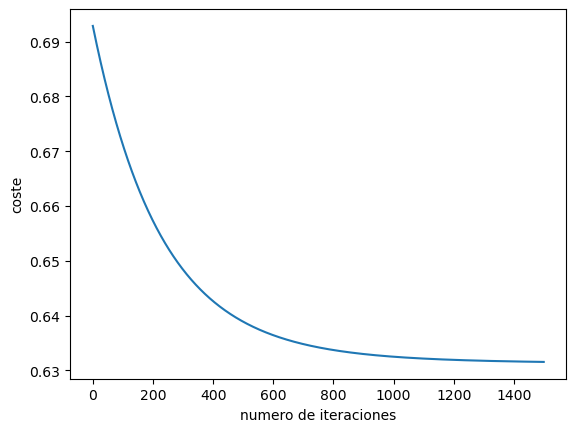

In [18]:
# Comenzamos con theta a 0's y utilizamos la función anterior para optimizar sus valores para obtener el nuevo theta y el historial del coste
theta = np.zeros(shape=[X.shape[1],1])
theta, costs_history = gradient_descent(X, y, theta,alpha=0.000001)
print('theta: ',theta.ravel())
print(f"El coste final es {costs_history[-1]}")

# Muestra la gráfica con la evolución del coste J obtenido de la salida de descenso_gradiente

plt.figure()
plt.plot(np.arange(costs_history.size),costs_history)
plt.xlabel('numero de iteraciones')
plt.ylabel('coste')
plt.show()

#### Descenso por gradiente utilizando SciPy

Otra forma de realizar el descenso por gradiente es utilizar la función [`minimize` de SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html), importada al comienzo de la práctica. Esta función realiza el proceso de descenso por gradiente y recibe como parámetros de entrada:
* La función que calcula el coste del modelo.
* Los valores iniciales de los parámetros del modelo (variable `theta_inicial`).
* Los valores de los ejemplos de entrenamiento (tanto de las variables de entrada ($X$) como de salida ($y$)) en forma de tupla (parámetro `args`).
* La función que realiza las derivadas parciales (parámetro `jac`).
* El número máximo de iteraciones del descenso por gradiente (establecido a 400).

Los parámetros del modelo aprendidos ($\theta$) se devuelven en el campo `x` de la variable utilizada para recoger la salida de la función `minimize`. En este caso se pueden consultar imprimiendo `res.x`. Este vector está en formato de fila. Pásalo a formato columna para poder seguir usándo la variable thetas como hasta ahora.

In [19]:
# Utiliza la función minimize para obtener los parámetros theta  
# Los primeros dos parámetros son la función de coste y los valores de theta iniciales (en formato fila).
thetas = np.zeros(X.shape[1])
res = minimize(cost_function, thetas, args=(X, y), jac=compute_gradients, options={'maxiter': 400})

# Obtén los valores de thetas a partir de res.x y pásalos a formato columna. Guarda el resultado en thetas
thetas = res.x.reshape(-1, 1)
print(thetas)

[[-25.16131634]
 [  0.2062316 ]
 [  0.20147143]]


/var/folders/x1/zlr91hyj1kb9jx7yvlg1rcn80000gn/T/ipykernel_84240/861646242.py:12: RuntimeWarning: divide by zero encountered in log
  second_part = np.log(1-g).T @(1-y) #(1,1)
/var/folders/x1/zlr91hyj1kb9jx7yvlg1rcn80000gn/T/ipykernel_84240/861646242.py:12: RuntimeWarning: invalid value encountered in matmul
  second_part = np.log(1-g).T @(1-y) #(1,1)
/var/folders/x1/zlr91hyj1kb9jx7yvlg1rcn80000gn/T/ipykernel_84240/861646242.py:12: RuntimeWarning: divide by zero encountered in log
  second_part = np.log(1-g).T @(1-y) #(1,1)
/var/folders/x1/zlr91hyj1kb9jx7yvlg1rcn80000gn/T/ipykernel_84240/861646242.py:12: RuntimeWarning: invalid value encountered in matmul
  second_part = np.log(1-g).T @(1-y) #(1,1)


> **Nota:** Puede que aparezca un Warning sobre una división por cero. Si la has controlado adecuadamente como sugeríamos, no debes preocuparte.

In [20]:
test_nb(list(np.round(thetas, 5)), [-25.16132, 0.20623, 0.20147], 'Valores de theta incorrectos')

✔️ Test passed.


#### Predicción de nuevos datos

Vamos primero a comprobar cómo podemos obtener la predicción para un nuevo ejemplo. Calcula la probabilidad de admisión de un estudiante que ha obtenido un 45 en el primer examen y un 85 en el segundo. Para ello, tendrás que hacer uso de las `thetas` y de la función `sigmoid` que nos devuelve la probabilidad de que un estudiante sea admitido (número entre 0 y 1 como se ha mencionado en el apartado previo) .

Puedes seguir los siguientes pasos:
1. Define un array de numpy con los datos del alumno para que pueda ser predicho por el modelo (recuerda incluir el 1 correspondiente a $\theta_0$).
2. Utiliza la función `sigmoid` para clasificar el alumno junto con los parámetros del modelo ($\theta$). Recuerda que en regresión logística $h_\theta(x) = g(\theta^Tx)$, donde $g$ es la función sigmoide.

In [21]:
# Predecir utilizando los theta obtenidos tras aplicar la función minimize (thetas) - guardar resultado en probabilidad
datos_alumno = np.array([1, 45.0, 85.0])
probabilidad = sigmoid(datos_alumno @ thetas)
print(probabilidad)

[0.77629032]


In [22]:
test_nb(np.round(probabilidad, 5), 0.77629, 'Valor de probabilidad incorrecto')

✔️ Test passed.


Con esto obtenemos la probabilidad de ser admitido. Después, deberíamos de aplicar un umbral (típicamente 0.5) para predecir la clase (admitido o no admitido). Vamos a crear ahora una función que lo integre todo para varios ejemplos a la vez.

Define una función que recibe los valores de los parámetros del modelo ($\theta$), una lista de lista con los valores de las variables de entrada de todos los alumnos ($X$) y un umbral para decidir si se predice la clase admitido o no admitido. Dado que la función `sigmoid` nos devolverá un valor en el intervalo $[0, 1]$, utilizaremos el umbral para transformar este valor a $0$ o $1$, dependiendo de si el valor devuelto por la función `sigmoid` es menor que el umbral (asignaremos `False` o `0`) o mayor o igual que este (en cuyo caso asignaremos `True`o `1`). El valor del umbral por defecto será $0.5$ para que ambas clases tengan la misma probabilidad de ser predichas.

Por tanto, crea una función `predict` que realice las siguientes tareas:
1. Calcula la probabilidad de admisión de todos los alumnos. Asigna estas probabilidades a la variable `prob`.
2. Compara las probabilidades en `prob` con el umbral para decidir si son admitidos (mayor o igual que el umbral: `True`) o no (menor que el umbral: `False`). Este resultado se almacenará en la variable `pred`.
3. La función devolverá tanto las probabilidades como las predicciones.

> **Nota:** No utilices ningún `for` dentro de la función, no es necesario.

In [23]:
def predict(theta, X, umbral=0.5):
    probs = sigmoid(X @ theta)
    preds = np.where(probs >= umbral, True, False)
    # La función astype la utilizamos para convertir booleanos (False (0), True (1)) en números enteros {0, 1}.
    return probs, preds.astype('int')

Utiliza la función anterior para predecir todos los ejemplos de entrenamiento y calcular el porcentaje de acierto:
1. Realiza la predicción de todos los alumnos en `X`usando la función `predict`.
2. Obtén el porcentaje de acierto comparando las predicciones con las salidas deseadas en `y`. Una forma de hacerlo es la siguiente.
    a. Compara la predicción `preds` con `y`.
    b. Calcula el número de alumnos correctamente predichos, sumando el array resultado de la comparación anteriore.
    c. Calcula el porcentaje de alumnos correctamente predichos dividiendo la suma anterior entre el número total de alumnos (`y.size`) y multiplica el resultado por 100. Este resultado debes almacenarlo en la variable `accuracy`.

In [24]:
test_nb(round(accuracy, 1), 89.0, 'Valor de accuracy incorrecto')

NameError: name 'accuracy' is not defined

#### Frontera de decisión

Ahora vamos a mostrar la frontera de decisión que genera el modelo de regresión logística que acabamos de aprender. Recuerda que la frontera de decisión se genera en el punto en el que las probabilidades del ejemplo a todas las clases son iguales y, por tanto, no se sabe determinar la clase. A partir de ese punto la clase cambia entre las que estén afectadas por la frontera (generalmente dos).

Vamos a crear una función ya que la reutilizaremos posteriormente.

In [ ]:
def plot_logistic_regression(thetas, x1_lim, x2_lim, ax=None):
    if ax is None:
        fig, ax= plt.subplots(figsize=(8, 6))

    # Usa la función meshgrid para generar una malla de puntos con todas 
    # las combinaciones entre los vectores que recibe como parámetro
    xx1, xx2 = np.meshgrid(np.linspace(*x1_lim, 200),
                         np.linspace(*x2_lim, 200))
    
    # Ponemos las combinaciones generadas en el formato adecuado para predecir
    X = np.hstack((xx1.reshape(-1, 1),
                     xx2.reshape(-1, 1)))
    
    # Añadimos una columna de unos a X
    X = np.hstack((np.ones((X.shape[0], 1)), X))    
      
    # Clasificamos los puntos con nuestro modelo
    # probs, pred = ...
    probs, preds = predict(thetas, X)
    
    # Hacemos reshape a las predicciones y a las probabilidades para que tengan el shape de xx
    probs = probs.reshape(xx1.shape)
    preds = preds.reshape(xx1.shape)
    
    # Pintamos las fronteras
    # Sombreamos las predicciones
    ax.pcolormesh(xx1, xx2, preds, cmap=ListedColormap(['r', 'b']), shading='auto', alpha=0.15)
    # Mostramos con una línea  todas las combinaciones cuya probabilidad de admisión sea 0.5 (equiprobable: no sabemos elegir)
    ax.contour(xx1, xx2, probs, [0.5], linewidths=1, colors='k', linestyles='dashed');
                                  
    # Establecemos los límites
    ax.set_xlim(*x1_lim)
    ax.set_ylim(*x2_lim)
                                  
    return ax 

Vamos ahora a pintar la frontera usando la función anterior.

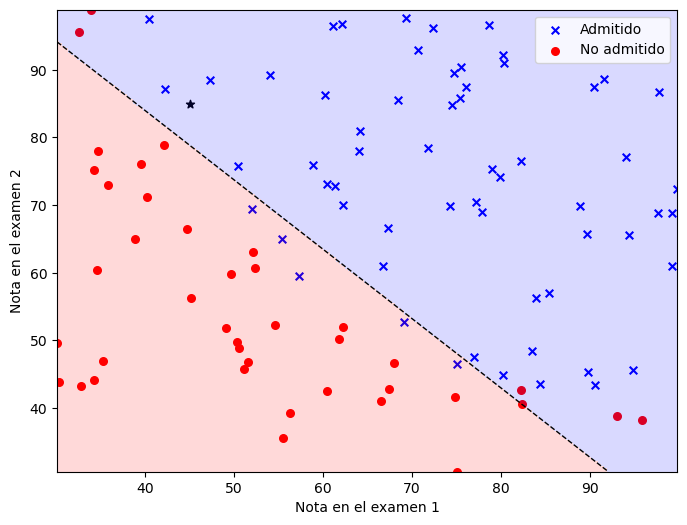

In [ ]:
# En primer lugar, mostramos la gráfica de los datos usando la función definida al inicio
fig, ax = plt.subplots(figsize=(8,6))
plot_data(X, y, "Nota en el examen 1", "Nota en el examen 2", "Admitido", "No admitido", ax=ax)

# Mostramos el punto que hemos clasificado anteriormente como una estrella negro
ax.scatter(datos_alumno[1], datos_alumno[2], marker="*", color="black")

# Calculamos el mínimo y máximo de cada variable de entrada
x1_lim = (X[:, 1].min(), X[:, 1].max())
x2_lim = (X[:, 2].min(), X[:, 2].max())

# Pintamos la frontera de decisión de la regresión logística
ax = plot_logistic_regression(thetas, x1_lim, x2_lim, ax)

#### Regresión logísticas con Scikit-learn
Al igual que con la regresión lineal, el paquete scikit-learn también tiene el método de la regresión logística implementado. Lo puedes consultar [aquí](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression).

Vamos a comprobar si el resultado obtenido es similar. Para ello, vamos a volver a pintar la gráfica anterior, pero entrenaremos el modelo con la clase `LogisticRegression` de scikit-learn. La regresión logística de de sklearn está implementada con la regularización, pero eso lo veremos en la segunda parte de la práctica. 
 
`LogisticRegression` requiere de los siguientes parámetros:
* `penalty`: Elegir `'l2'` (es el tipo de regularización a realizar).
* `C`: Es el valor que corresponde a lambda, pero en este caso $ C = 1/\lambda$. Como no queremos regularizar, este valor debe ser un valor muy alto, por ejemplo $10.0e50$.
* `max_iter`: Número máximo de iteraciones para el descenso por gradiente (`400`).
* `solver`: Este es el método a utilizar para buscar el mínimo. Puede ser cualquiera de entre `{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’}`. Utilizar `'newton-cg'` para esta prueba.

Una vez creado el objeto de `LogisticRegression` debes utilizar el método `fit`. Como entrada toma la matriz $X$ (**CUIDADO** sin coger la columna de unos) y el vector $y$ (ponerlo en modo vector usando `ravel()`).

Con dicha operación logramos ajustar los parámetros y ya podemos usar el objeto para predecir nuevos valores (los coeficientes obtenidos están en `coef_` y `intercept_`, pero es más sencillo utilizar la función `predict_proba` para obtener las probabilidades de salida para cada ejemplo. Esta función recibe la matriz $X$ de entrada (sin la columna de unos) y devuelve una matriz de $m \times 2$. De esta matriz solo nos interesa la segunda columna que es la que tiene la probabilidad de que un ejemplo pertenezca a la clase 1. 

Vamos a entrenar un modelo de regresión lineal con scikit-learn:

In [ ]:
# Se importa de la libreria scikit-learn de python (sklearn) el paquete correspondiente a la regresión lineal
from sklearn.linear_model import LogisticRegression

# solver : {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’}
# Incializa el modelo llamando al constructor de la regresión lineal: 
# todos los parámetros se asignan a los valores comentados anteriores
# Almacenar objeto en reg
reg = LogisticRegression(penalty='l2', C=10.0e50, max_iter=400, solver='newton-cg')
reg.fit(X[:,1:], y.ravel())


# Entrena el modelo (aprendizaje) utilizando la variable de entrada sin los unos X[:,1] y la variable de salida (y)
# La función ravel devuelve una lista (si la entrada es una lista de listas coge todos los elementos y los almacena en la lista devuelta)
theta = np.concatenate((reg.intercept_, reg.coef_[0]))
print(theta)

[-25.14977259   0.20613885   0.20137835]


Utiliza ahora este modelo para predecir el mismo ejemplo que antes (un alumno con un 45 en el primer examen y un 85 en el segundo). Obtén tanto su predicción (con `predict`) como la probabilidad (con `predict_proba`).

In [25]:
# Obtén tanto la probabilidad de aprobar como la predicción para un alumno con un 45 en el primer examen y un 85 en el segundo
# Almacena los resultados en pred y prob, respectivamente
student = np.array([1,45.0,85.0])

_, prob = reg.predict_proba(student[1:].reshape(-1,2))[0]
_, pred = predict(theta, student)
print(pred, prob)

NameError: name 'reg' is not defined

In [ ]:
test_nb(pred, 1.0, 'Valor de pred incorrecto')
test_nb(np.round(prob, 4), 0.7762, 'Valor de prob incorrecto')

✔️ Test passed.
✔️ Test passed.


Vamos ahora a visualizar la frontera de decisión del modelo de scikit-learn. De nuevo, crearemos una función para ello.

In [ ]:
def plot_logistic_regression_sklearn(reg, x1_lim, x2_lim, ax=None):
    if ax is None:
        fig, ax= plt.subplots(figsize=(8, 6))

    # Usa la función meshgrid para generar una malla de puntos con todas 
    # las combinaciones entre los vectores que recibe como parámetro
    xx1, xx2 = np.meshgrid(np.linspace(*x1_lim, 200),
                         np.linspace(*x2_lim, 200))
    
    # Ponemos las combinaciones generadas en el formato adecuado para predecir
    X = np.hstack((xx1.reshape(-1, 1),
                     xx2.reshape(-1, 1)))
          
    # Clasificamos los puntos con nuestro modelo
    probs = reg.predict_proba(X)[:,1]
    preds = probs >= 0.5
    
    # Hacemos reshape a las predicciones y a las probabilidades para que tengan el shape de xx1
    probs = probs.reshape(xx1.shape)
    preds = preds.reshape(xx1.shape)
    
    # Pintamos las fronteras
    # Sombreamos las predicciones
    ax.pcolormesh(xx1, xx2, preds, cmap=ListedColormap(['r', 'b']), shading='auto', alpha=0.15)
    # Mostramos con una línea  todas las combinaciones cuya probabilidad de admisión sea 0.5 (equiprobable: no sabemos elegir)
    ax.contour(xx1, xx2, probs, [0.5], linewidths=1, colors='k', linestyles='dashed');
                                  
    # Establecemos los límites
    ax.set_xlim(*x1_lim)
    ax.set_ylim(*x2_lim)
                                  
    return ax 

A continunación, ya podemos utilizar la función para pintar la frontera de decisión.

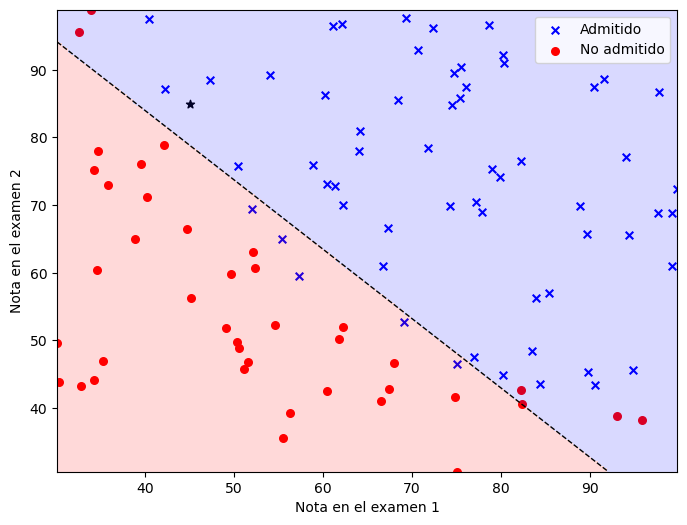

In [ ]:
# En primer lugar, mostramos la gráfica de los datos usando la función definida al inicio
fig, ax = plt.subplots(figsize=(8,6))
plot_data(X, y, "Nota en el examen 1", "Nota en el examen 2", "Admitido", "No admitido", ax=ax)

# Mostramos el punto que hemos clasificado anteriormente como una estrella negro
ax.scatter(student[1], student[2], marker="*", color="black")

# Pintamos la frontera de decisión de la regresión logística
x1_lim = (X[:, 1].min(), X[:, 1].max())
x2_lim = (X[:, 2].min(), X[:, 2].max())

ax = plot_logistic_regression_sklearn(reg, x1_lim, x2_lim, ax)

### Regresión logística con regularización <a id="regularizacion"></a>

En esta segunda parte de la práctica vamos a trabajar con un nuevo problema de clasificación. En este caso se trata de predecir si un microchip pasa los tests de calidad o no. Para ello, a cada microchip se le realizan dos tests, cuyos resultados se almacenan en un archivo que contiene los datos históricos de 118 microchips. Por tanto, para cada microchip se tienen dos variables de entrada (los resultados de los dos tests) y la variable de salida que tiene dos valores: pasa el test de calidad, son aceptados, (1) o no, son rechazados, (0). Los datos de este problema están almacenados en el fichero llamado `'microchips.txt'` cuyo delimitador también es la coma (`','`).

Comienza realizando la llamada a la función que realiza la lectura de los ficheros y guarda los datos los datos en la variable `data_2`.

In [ ]:
# Lee los datos en data2
data2 = read_data('microchips.txt',',')

Dimensiones de los datos:  (118, 3)
[[ 0.051267  0.69956   1.      ]
 [-0.092742  0.68494   1.      ]
 [-0.21371   0.69225   1.      ]
 [-0.375     0.50219   1.      ]
 [-0.51325   0.46564   1.      ]]


Ahora, crea las variables de entrada ($X$) y de salida ($y$). En este caso no añadas la columna de unos a $X$, ya que vamos a realizar alguna que otra transformación antes.

In [ ]:
X = data2[:,:-1]
y = data2[:,-1].reshape(-1,1)



In [ ]:
test_nb(list(X[0,:]), [0.051267, 0.69955999999999996], 'X no está bien formada')
test_nb(list(y[:5, 0]), [1.0, 1.0, 1.0, 1.0, 1.0], 'y no está bien formada')

✔️ Test passed.
✔️ Test passed.


Vamos a visualizar los nuevos datos. Utiliza a la función que muestra la gráfica con los ejemplos del histórico de microchips y nombra correctamente los ejes y lo títulos de la leyenda. La clase positiva (1) son los microchips aceptados y la clase negativa (0) los rechazados.

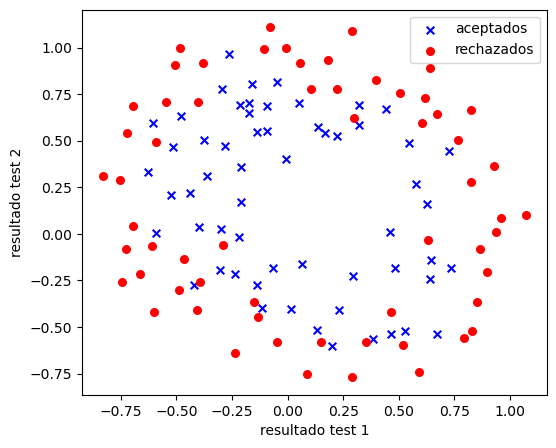

In [ ]:
ax = plot_data(X,y, "resultado test 1", "resultado test 2", "aceptados", "rechazados")

Parece evidente que en este caso los ejemplos no son linealmente separables y vamos a tener que crear variables polinómicas.

#### Características polinomiales

Como podemos ver en la gráfica anterior los ejemplos no son linealmente separables. Por este motivo, en primer lugar, vamos a crear nuevas variables que nos permitan obtener fronteras de decisión no lineales. Para ello vamos a utilizar la función [`PolynomialFeatures` que nos provee scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html).

Sigue los siguientes pasos:
1. Instancia un objeto, `poly`, de la clase `PolynomialFeatures` pasando como parámetro de entrada el valor 6 ya que vamos a generar todos los términos polinómicos de $x_1$ y $x_2$ hasta la potencia 6: en total hay 27 combinaciones (por tanto se generan 27 variables). Para que no nos introduzca la columna de todo 1s (no nos interesa), usaremos `include_bias=False`.
2. Una vez creado el objeto que nos permite realizar dicha transformación llamamos a la función `fit_transform` utilizando como parámetro la matriz $X$ que contiene los valores de las variables de entrada de nuestro problema.
3. Esta función tiene dos partes (`fit` y `transform`).
    1. La parte `fit` aprende los polinomios para generar las nuevas variables.
    2. La parte `transform` aplica los polinomios generados para transformar los datos de entrada y que como consecuencia pasemos de tener dos variables de entrada a 27.

> **NOTA:** los términos polinómicos de las variables $a$ y $b$ hasta la potencia $p=3$ serían: $1, a, b, a^2, b^2, a^3, b^3, a \cdot b, a \cdot b^2, a^2\cdot b^2$. Es decir, cada variable se eleva a todas las potencias entre 0 y $p$, y las combinaciones entre ellas no incluyen los términos elevados a $p$.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(6, include_bias=False)
X_poly = poly.fit_transform(X)
# Almacena en X_poly el nuevo conjunto de datos transformado
# Recuerda utilizar el parámetro include_bias=False.

print(X_poly.shape)

(118, 27)


No olvidemos que, especialmente cuando utilizamos características polinomiales, es necesario normalizar los datos. 

Para ello, vamos a utilizar la función [`StandardScaler` de Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

Para utilizarla, debemos seguir los siguientes pasos:
* Instancia un objeto, `scaler`, de la clase `StandardScaler` con los parámetros de entrada por defecto.
* Una vez creado el objeto que nos permite realizar dicha transformación llamamos a la función `fit_transform` utilizando como parámetro la matriz `X_poly` que contiene los valores de las variables de entrada de nuestro problema.
* Esta función tiene dos partes (`fit` y `transform`)
    * La parte `fit` calcula las medias y desviaciones típicas para llevar a cabo la estandarización.
    * La parte `transform` aplica la estandarización los datos. Es importante hacer notar que cuando queramos normalizar ejemplos de test, únicamente deberemos llamar a esta función `transform()`y nunca a `fit_transform()`, ya que recalcularía las medias y desviaciones sobre el conjunto de test.

Después de normalizar vamos a a añadir una columna de unos. 
  

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_poly_norm = scaler.fit_transform(X_poly)

# Almacena en X_poly_norm el nuevo conjunto de datos transformado
# scaler = ...
# X_poly_norm = ...
X_poly_norm = np.column_stack([np.ones(shape=[X_poly_norm.shape[0],1]), X_poly_norm])

In [ ]:
test_nb(np.round(X_poly.sum(), 5), 210.70899, 'Xpoly incorrecto')
test_nb(np.round(X_poly_norm.sum(), 2), 118.00, 'Xpoly_norm incorrecto')

✔️ Test passed.
✔️ Test passed.


#### Implementación propia de Regresión logística con regularización

##### Función de coste regularizada
Al haber añadido tantas variables, corremos el serio riesgo de ajustarnos demasiado a los datos de entrenamiento (sobreaprender) y por tanto de no generalizar bien para nuevos ejemplos. Por ello, vamos a implementar la regresión logística con regularización en la que se penalizan aquellos parámetros con valores muy grandes, haciendo que el modelo no pueda ajustarse perfectamente a los datos de entrenamiento con el objetivo de obtener una mejor generalización.

Veamos cómo cambia la función de coste:

$$ J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}\big[y^{(i)}\, log\,( h_\theta\,(x^{(i)}))+(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$


Observa que se introduce el sumatorio de los parámetros $\theta$ al cuadrado ponderado por el valor del parámetro $\lambda$.
* Si $\lambda=0$ obtenemos la función de coste implementada en la primera parte de la práctica.
* Si $\lambda>0$ la función de coste trata de disminuir el valor de los parámetros $\theta$ del modelo. A mayor valor de $\lambda$, menores serán los valores de los parámetros $\theta$ que obtenedremos, ya que trataremos de minimizarlos (al ser parte de la la función de coste).

La misma función la podemos expresar de forma **vectorizada** de la siguiente forma:

$$ J(\theta) = -\frac{1}{m}\big((\,log\,(h_\theta(X))^Ty+(\,log\,(1-h_\theta(X))^T(1-y)\big) + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$

donde

$$ h_\theta(X) = g(X\cdot \theta) $$

Ahora, implementa la función de coste que inluye la regularización. Para ello, debes seguir usando la función sigmoide definida en la primera parte de la práctica.

> **CUIDADO:** Recuerda que el $\theta_0$ no se regulariza.

In [ ]:
def cost_function_reg(theta, valor_lambda, X, y):

    #Nos aseguramos de las dimensiones correctas
    theta = theta.reshape(-1,1)
    y = y.reshape(-1,1) 
    m = y.size #numero de ejemplos


    J = cost_function(theta, X, y)
    J += (valor_lambda/(2*m)) * np.sum(theta[1:]**2) 
    
    if np.isnan(J).any():
        J = np.inf
    # Controla que si el coste es NaN la salida sea np.inf. Puede darse debido a los logaritmos
    return J 

Vamos a comprobar ahora que la función está correctamente implementada.
1. Inicializa los valores iniciales de la regresión logística a una columna de con valores $0.5$.
2. Llama a la función que calcula el coste del modelo con los datos transformados (`X_poly_norm`) y el parámetro $\lambda=1.0$.

In [ ]:
# Columna de ceros como valores inciales de los parametros del modelo (guardar en theta_inicial)
theta_inicial = np.ones(X_poly_norm.shape[1], dtype=np.float32) * 0.5
# Llamada a la funcion que calcula el coste del modelo inicial (guardar en coste)
cost = cost_function_reg(theta_inicial, 1.0, X_poly_norm, y)

print('Coste del modelo inicial: \n', cost)

Coste del modelo inicial: 
 3.554916020568302


In [ ]:
test_nb(np.round(cost, 5), 3.55492,'Valor de coste incorrecto')

✔️ Test passed.




##### Derivada parcial

Vamos a seguir los mismos pasos que antes para implementar la regresión logística regularizada. Volveremos a utilizar la función `minimize` en vez de implementar el descenso por gradiente al completo. Para ello, debemos crear una función que calcule las derivadas parciales de los parámetros. Recordamos las derivadas parciales de la regresión logística regularizada:

$$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})\cdot x^{(i)}_{j} + \frac{\lambda}{m}\theta_{j}$$ 

La misma fórmula la podemos expresar de forma **vectorizada**:

$$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(h_\theta(X)-y) + \frac{\lambda}{m}\theta_{j}$$

> **CUIDADO:** Recuerda que el $\theta_0$ no se regulariza y por tanto, su derivada parcial no cambia respecto al caso sin regularizar.

Vamos ahora a implementar esta fórmula utiliznado la expresión vectorizada.

> **NOTA:** Esta función la vamos a usar en una función minimize que realizará el descenso por gradiente. Dicha función en vez de pasar theta como una matriz de (3, 1), nos pasará una de (3, ) por lo que debes hacer un reshape antes de realizar el producto entre X y theta.

In [ ]:
def compute_gradients_reg(theta, valor_lambda, X, y):
    theta = theta.reshape(-1,)
    m = y.size

    der_parcial = compute_gradients(theta, X, y)
    der_parcial += (valor_lambda/m)* theta
    der_parcial[0] = compute_gradients(theta, X, y)[0]

    return der_parcial.flatten()  # La salida debe ser un vector

Vamos a comprobar ahora que las función está correctamente implementada. 

Llama a la función que calcula la derivada parcial con los mismos parámetros que antes y comprueba que funciona correctamente.

In [ ]:
# Llamada a la funcion que realiza la derivada parcial (guardar en grads)
grads = compute_gradients_reg(theta_inicial, 1.0, X_poly_norm, y)

print('Gradientes: \n', grads)

Gradientes: 
 [-0.16108872  0.26072832  0.23151341  0.31390611  0.2638503   0.31314954
  0.27766835  0.22604474  0.2045786   0.30389084  0.32609522  0.21227124
  0.31394031  0.1883444   0.33154734  0.28082851  0.20159626  0.21804645
  0.27195887  0.14322456  0.30991862  0.30065754  0.18274902  0.29618371
  0.17982569  0.30072421  0.11602185  0.31094039]


In [ ]:
test_nb(list(np.round(grads[0:5], 5)), [-0.16109,  0.26073,  0.23151,  0.31391,  0.26385], 'Valores de la derivada parcial incorrectos. Revisa si estás regularizando theta 0 adecuadamente')

✔️ Test passed.


Es momento de comprobar si podemos aprender la regresión logística con regularización para el problema previamente planteado usando la función `minimize`. Si recuerdas sus parámetros, solo debes sustituir las nuevas funciones de coste y del cálculo de gradientes. En resumen, los argumentos de entrada son:
* La función que calcula el coste del modelo.
* Los valores iniciales del modelo que acabamos de asignar (**en una fila**).
* Una tupla que contiene: el valor de $\lambda$, los datos transformados (`X_poly_norm`) y las clases de los 118 ejemplos (parámetro `args`).
* La función que realiza la derivada parcial de los parámetros del modelo (parámetro `jac`).
* El número máximo de iteraciones que lo fijamos a 3000.

> **Nota**: Utiliza la variable de thetas inicializada previamente a 0.5.

In [ ]:
# Entrena un modelo de regresión logística regularizada con lambda = 1 y 3000 iteraciones usando minimize
# Recuerda que los theta deben ir en formato fila (usar .ravel())
res2 = minimize(cost_function_reg, theta_inicial.ravel(), args=(1, X_poly_norm, y), jac=compute_gradients_reg, options={'maxiter': 3000})

thetas = res2.x.ravel()
thetas
print(np.round(thetas,5)[:5])

[-0.52929  0.70871  1.30929 -0.6853  -0.89844]


In [ ]:
test_nb((np.round(thetas,5)[:5]==[-0.52929,0.70871,1.30929,-0.6853,-0.89844]).all(),True, 'Valor de thetas incorrecto')

✔️ Test passed.


Si ahora queremos usar estos parámetros para predicr nuevos datos, debemos recordar que será necesario transformar estos antes, generando las características polinomiales y normalizando sus valores de acuerdo a las medias y desviaciones calculadas en entrenamiento. Predice el resultado de un chip con un valor de -0.5 en el primer test y 0.5 en el segundo.,

In [ ]:
# Calcula la probabilidad y la predicción del modelo para un microchip con valores -0.5 y 0.5
# Recuerda añadir características polinomiales y normalizar después usando los objetos poly y scaler
# Es importante NO usar fit_transform, sino transform
# Recuerda que tras llamar al scaler, es necesario añadir el 1 correspondiente al término independiente
micro = np.array([-0.5, 0.5]).reshape(1,-1)

micro_poly = poly.transform(micro)
micro_poly_norm = scaler.transform(micro_poly)

ones = np.ones(shape=[micro_poly_norm.shape[0], 1])
micro_poly_norm = np.hstack((ones, micro_poly_norm))

prob, pred = predict(thetas, micro_poly_norm)
print(prob, pred)

[0.81438956] [1]


In [ ]:
test_nb(pred, 1.0, 'Valor de pred incorrecto')
test_nb(np.round(prob, 4), 0.8144, 'Valor de prob incorrecto')

✔️ Test passed.
✔️ Test passed.


Para poder visualizar la frontera de decisión necesitamos modificar nuestra función añadiendo dos parámetros: `poly` y `scaler`, que nos indicarán si nuestros datos han sido transformados o no, y nos permitirán hacer el proceso correspondiente.

In [ ]:
def plot_logistic_regression(thetas, x1_lim, x2_lim, poly=None, scaler=None, ax=None):
    if ax is None:
        fig, ax= plt.subplots(figsize=(8, 6))

    # Usa la función meshgrid para generar una malla de puntos con todas 
    # las combinaciones entre los vectores que recibe como parámetro
    xx1, xx2 = np.meshgrid(np.linspace(*x1_lim, 200),
                         np.linspace(*x2_lim, 200))
    
    # Ponemos las combinaciones generadas en el formato adecuado para predecir
    X = np.hstack((xx1.reshape(-1, 1),
                     xx2.reshape(-1, 1)))

    # Aplicamos las transformaciones necesarias
    if poly:
        # Aplica la transformación de las características polinomiales
        # X = ...
        X = poly.transform(X)
    if scaler:
        # Aplica la transformación de la estandarización
        # X = ...
        X = scaler.transform(X)
    
    # Añadimos una columna de unos a X
    X = np.hstack((np.ones((X.shape[0], 1)), X))    
      
    # Clasificamos los puntos con nuestro modelo
    probs, preds = predict(thetas, X)
    
    # Hacemos reshape a las predicciones y a las probabilidades para que tengan el shape de xx
    probs = probs.reshape(xx1.shape)
    preds = preds.reshape(xx1.shape)
    
    # Pintamos las fronteras
    # Sombreamos las predicciones
    ax.pcolormesh(xx1, xx2, preds, cmap=ListedColormap(['r', 'b']), shading='auto', alpha=0.15)
    # Mostramos con una línea  todas las combinaciones cuya probabilidad de admisión sea 0.5 (equiprobable: no sabemos elegir)
    ax.contour(xx1, xx2, probs, [0.5], linewidths=1, colors='k', linestyles='dashed');
                                  
    # Establecemos los límites
    ax.set_xlim(*x1_lim)
    ax.set_ylim(*x2_lim)
                                  
    return ax 

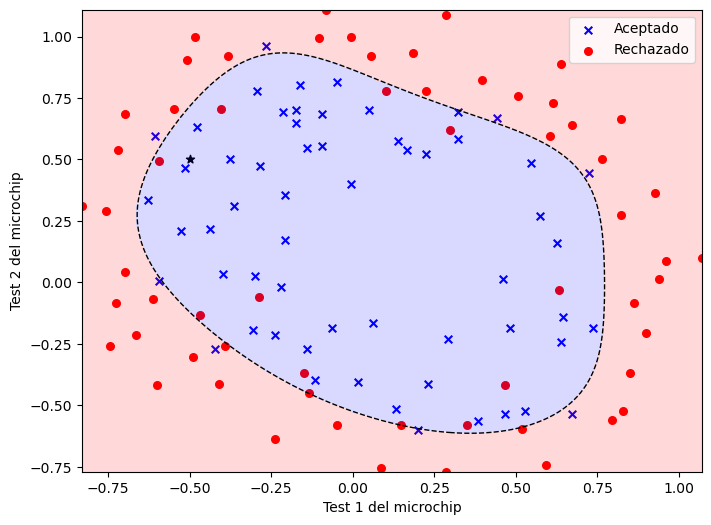

In [ ]:
# En primer lugar, mostramos la gráfica de los datos usando la función definida al inicio
fig, ax = plt.subplots(figsize=(8,6))
plot_data(X, y, "Test 1 del microchip", "Test 2 del microchip", "Aceptado", "Rechazado", ax=ax)

# Mostramos el punto que hemos clasificado anteriormente como una estrella negro
ax.scatter(micro[0][0], micro[0][1], marker="*", color="black")

# Calculamos el mínimo y máximo de cada variable de entrada
x1_lim = (X[:, 0].min(), X[:, 0].max())
x2_lim = (X[:, 1].min(), X[:, 1].max())

# Pintamos la frontera de decisión de la regresión logística
ax = plot_logistic_regression(thetas, x1_lim, x2_lim, poly=poly, scaler=scaler, ax=ax)

Parece que tiene buena pinta! Ahora vamos a ver cómo influye el valor de $\lambda$ en los resultados.

#### Efecto de $\lambda$ en los resultados
Para nalizar el efecto del parámetro $\lambda$ en los resultados obtenidos vamos a probar 3 valores: 0, 1 y 100. Para cada valor hay que realizar el siguiente proceso:
1. Llama a la función `minimize` (descenso por gradiente) modificando el valor de $\lambda$.
2. Realiza la predicción de los ejemplos del histórico (datos guardados en `X_poly_norm`) con el modelo aprendido. Deberías utilizar la función `predict` definida anteriormente con los parámetros obtenidos del minimize (recuerda transformarlos a una columna).
3. Calcula el porcentaje de acierto del modelo (tal y como lo hemos hecho en la primera parte de la práctica).
4. Muestra la gráfica con la frontera de decisión generada por el modelo aprendido (utilizando la función definida previamente).
    * Como título de la figura mostrar el valor de $\lambda$ y el porcentaje de acierto.
5. Muestra los valores de los parámetros del modelo (`print`).

Deberías ser capaz de obtener las siguientes figura:

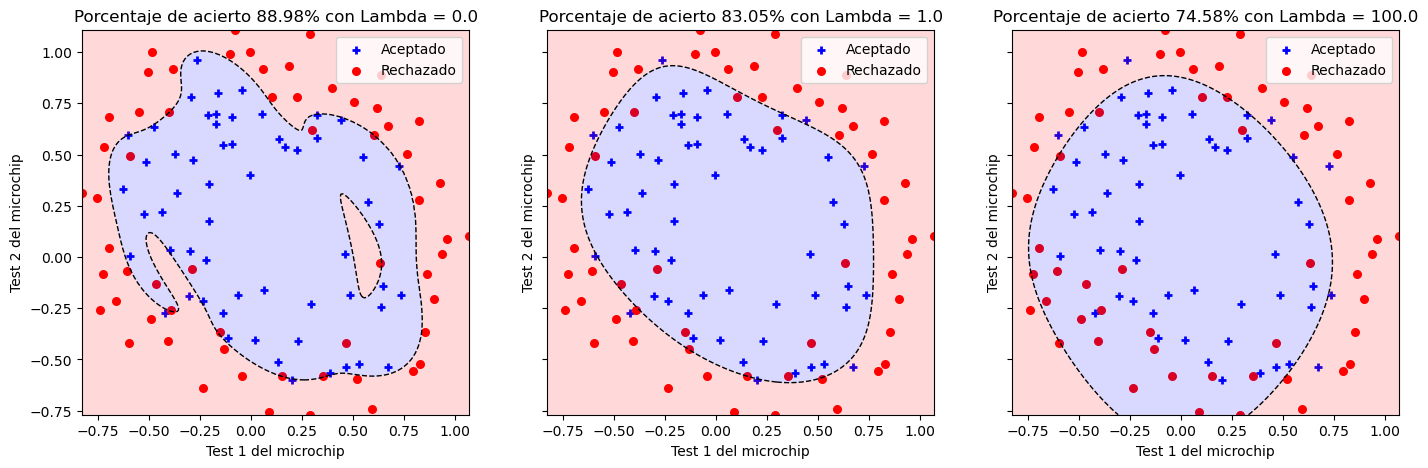

Los valores de theta para lambda = 0.0 son [ -26.11662823   27.49361846   50.80367569  -91.44331452  -39.5461983
  -55.05054147 -100.0909395  -112.99244425 -107.59396385 -166.27283336
  246.49526579  123.29190493  129.62707709  106.34101486  144.22144621
  122.60247572  117.30578763  138.76120862  170.12883436  177.26346628
  233.9429879  -242.85525412 -131.17087474 -141.53420291 -160.03441622
 -183.14439282 -185.5720621  -221.5596011 ]
Los valores de theta para lambda = 1.0 son [-0.52929145  0.70871488  1.30929322 -0.68530185 -0.89844188 -0.94605214
  0.32973052  0.36527363  0.14953724  0.22285608 -0.8655114  -0.13699312
 -0.23087187 -0.3677028  -0.89865285 -0.14049832 -0.05506605  0.64600076
 -0.28498181 -0.5005555  -0.09393634 -0.87551321 -0.03751219 -0.28102089
  0.3563908  -0.69186027 -0.41938576 -0.56370104]
Los valores de theta para lambda = 100.0 son [-0.05806898  0.01959006  0.05548813 -0.12989723 -0.04137115 -0.07925894
 -0.00182962 -0.00235862 -0.02300775 -0.01535371 -0.1204

/var/folders/x1/zlr91hyj1kb9jx7yvlg1rcn80000gn/T/ipykernel_16814/3325492889.py:2: RuntimeWarning: overflow encountered in exp
  return 1 /(1+np.exp(-z))


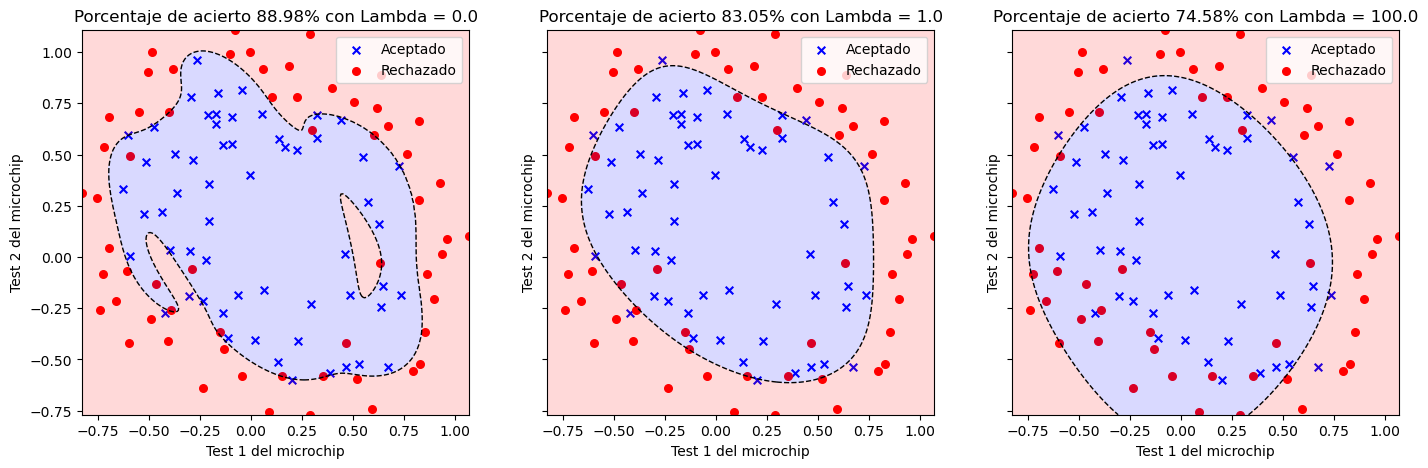

In [ ]:
# Queremos una figura con 3 subplots
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(17, 5))

# Fronteras de decisión
# Lambda = 0 : No se realiza regularización --> modelo muy flexible: sobre-entrenado
# Lambda = 1 : Parece que es un buen modelo: simple y preciso
# Lambda = 100 : Demasiada regularización: mucho bías

# Crea la variable valores_lambda
valores_lambda = [0.0, 1.0, 100.0]



for i, valor_lambda in enumerate(valores_lambda):
    # Optimización de los parámetros del modelo en base a la función de coste, utilizar minimize
    res2 = minimize(cost_function_reg, theta_inicial.ravel(), args=(valor_lambda, X_poly_norm, y), jac=compute_gradients_reg, options={'maxiter': 3000})

    # Ponemos los parámetros que están en res2.x en formato columna con reshape (guardar en thetas)
    thetas = res2.x.ravel()

    # Obtener las predicciones del modelo (thetas) para los datos transformados con los polinomios (XX)
    probs, preds = predict(thetas, X_poly_norm)
    # Calcular el porcentaje de acierto como hemos realizado en la primera parte de la práctica
    unique, counts = np.unique(np.where(preds == y.ravel(), True, False), return_counts=True)
    accuracy = (dict(zip(unique,counts)).get(True)/y.size)*100

    # Gráfica que muestra los ejemplos, utiliza como último parámetro axes.flatten()[i] (le pasamos el manejador de la figura correspondiente)
    plot_data(X, y, "Test 1 del microchip", "Test 2 del microchip", "Aceptado", "Rechazado", ax=axes.flatten()[i])
    
    # Mostramos la frontera de decisión
    plot_logistic_regression(thetas, x1_lim, x2_lim, poly=poly, scaler=scaler, ax=axes.flatten()[i]);
    # Establecemos el título
    axes.flatten()[i].set_title(
        'Porcentaje de acierto {}% con Lambda = {}'.format(
            np.round(accuracy, decimals=2), valor_lambda
        )
    )

    # Mostrar los valores de theta para cada lambda "Los valores de theta para lambda = XX son [a, b, c...]"
    print("Los valores de theta para lambda =", valor_lambda, "son", thetas)

In [ ]:
test_nb((np.round(thetas.T, 4)==[[-0.0581,  0.0196,  0.0555, -0.1299, -0.0414, -0.0793, -0.0018,
        -0.0024, -0.023 , -0.0154, -0.1204, -0.0047, -0.0985, -0.0153,
        -0.0885, -0.0305, -0.0168, -0.0099, -0.0366, -0.0282, -0.0509,
        -0.0993,  0.0051, -0.0979,  0.0098, -0.0864, -0.0067, -0.0827]]).all(),True, 'Valor de thetas con lambda = 100 incorrecto' )

✔️ Test passed.


#### Conclusiones

Podéis observar los siguientes hechos:
* Con $\lambda=0$ el modelo obtenido es muy complejo puesto que está muy ajustado a los datos con los que ha sido aprendido. El porcentaje de acierto es muy alto (91.53%) y los valores de los parámetros $\theta$ son **muy altos**.
* Con $\lambda=1$ el modelo obtenido es más sencillo y ofrece un buen balance entre complejidad y porcentaje de acierto (83.05%). Los valores de los parámetros $\theta$ son más bajos que antes.
* Con $\lambda=100$ el modelo obtenido es muy sencillo, pero no se ajusta bien a los datos de entrenamiento y por tanto se obtiene un porcentaje de acierto muy bajo para este problema (61.02%). Los valores de los parámetros $\theta$ son muy bajos.

#### Regresión logística regularizada con Scikit-learn
En este apartado vamos a tratar de replicar el resultado anterior con el paquete scikit-learn. Para ello, vamos a volver a pintar las gráficas anteriores, pero entrenaremos el modelo con la clase [`LogisticRegression` de scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression). 
 
`LogisticRegression` requiere de los siguientes parámetros:
* `penalty`: Elegir `'l2'` (es el tipo de regularización a realizar).
* `C`: Es el valor que corresponde a lambda, pero en este caso $ C = 1/\lambda$. Tenlo en cuenta a la hora de establecer el valor de `C`. Cuando no queremos aplicar la regularización, este valor debe ser muy alto, por lo que el valor de lambda debe ser muy bajo, por ejemplo $lambda =0.1e-100$.
* `max_iter`: Número máximo de iteraciones para el descenso por gradiente (`400`).
* `solver`: Este es el método a utilizar para buscar el mínimo. Puede ser cualquiera de entre {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’}. Utilizar `'newton-cg'` para esta prueba.

Una vez creado el objeto de `LogisticRegression` debes utilizar el método `fit`. Como entrada toma la matriz $X$ (**CUIDADO** sin coger la columna de unos) y el vector $y$ (ponerlo en modo vector usando `ravel()`).

Con dicha operación logramos ajustar los parámetros y ya podemos usar el objeto para predecir nuevos valores. Los coeficientes obtenidos están en `coef_` y `intercept_`, pero es más sencillo utilizar la función `predict_proba` para obtener las probabilidades de salida para cada ejemplo o la función `predict` para obte. La función `predict_proba` recibe la matriz $X$ de entrada (sin la columna de unos) y devuelve una matriz de $m \times 2$. De esta matriz solo nos interesa la segunda columna que es la que tiene la probabilidad de que un ejemplo pertenezca a la clase 1. En el caso de `predict`, recibe la misma matriz de entrada $X$, pero únicamente devuelve un vector con la salida para cada ejemplo.

Utiliza los conocimientos adquiridos en la primera parte de la práctica y en el ejercicio anterior para obtener unas figuras lo más parecidas posibles a las anteriores.

En primer lugar, para poder visualizar las fronteras de decisión, deberemos modificar la función correspondiente para que pueda recibir los objetos `poly`y `scaler`.

In [ ]:
def plot_logistic_regression_sklearn(reg, x1_lim, x2_lim, poly=None, scaler=None, ax=None):
    if ax is None:
        fig, ax= plt.subplots(figsize=(8, 6))

    # Usa la función meshgrid para generar una malla de puntos con todas 
    # las combinaciones entre los vectores que recibe como parámetro
    xx1, xx2 = np.meshgrid(np.linspace(*x1_lim, 200),
                         np.linspace(*x2_lim, 200))
    
    # Ponemos las combinaciones generadas en el formato adecuado para predecir
    X = np.hstack((xx1.reshape(-1, 1),
                     xx2.reshape(-1, 1)))
    
    # Aplicamos las transformaciones necesarias
    if poly:
        # Aplica la transformación de las características polinomiales
        X = poly.transform(X)
    if scaler:
        # Aplica la transformación de la estandarización
        X = scaler.transform(X)

    # Clasificamos los puntos con nuestro modelo
    coefs = reg.coef_
    indep = reg.intercept_

    thetas = np.concatenate((indep.ravel(),coefs.ravel()))
    probs, preds = predict(thetas[1:], X)
    
    # Hacemos reshape a las predicciones y a las probabilidades para que tengan el shape de xx1
    probs = probs.reshape(xx1.shape)
    preds = preds.reshape(xx1.shape)
    
    # Pintamos las fronteras
    # Sombreamos las predicciones
    ax.pcolormesh(xx1, xx2, preds, cmap=ListedColormap(['r', 'b']), shading='auto', alpha=0.15)
    # Mostramos con una línea  todas las combinaciones cuya probabilidad de admisión sea 0.5 (equiprobable: no sabemos elegir)
    ax.contour(xx1, xx2, probs, [0.5], linewidths=1, colors='k', linestyles='dashed');
                                  
    # Establecemos los límites
    ax.set_xlim(*x1_lim)
    ax.set_ylim(*x2_lim)
                                  
    return ax

Ahora ya puedes replicar el experimento realizado anteriormente con scikit-learn.

88.98305084745762
83.05084745762711
74.57627118644068


/var/folders/x1/zlr91hyj1kb9jx7yvlg1rcn80000gn/T/ipykernel_16814/3325492889.py:2: RuntimeWarning: overflow encountered in exp
  return 1 /(1+np.exp(-z))


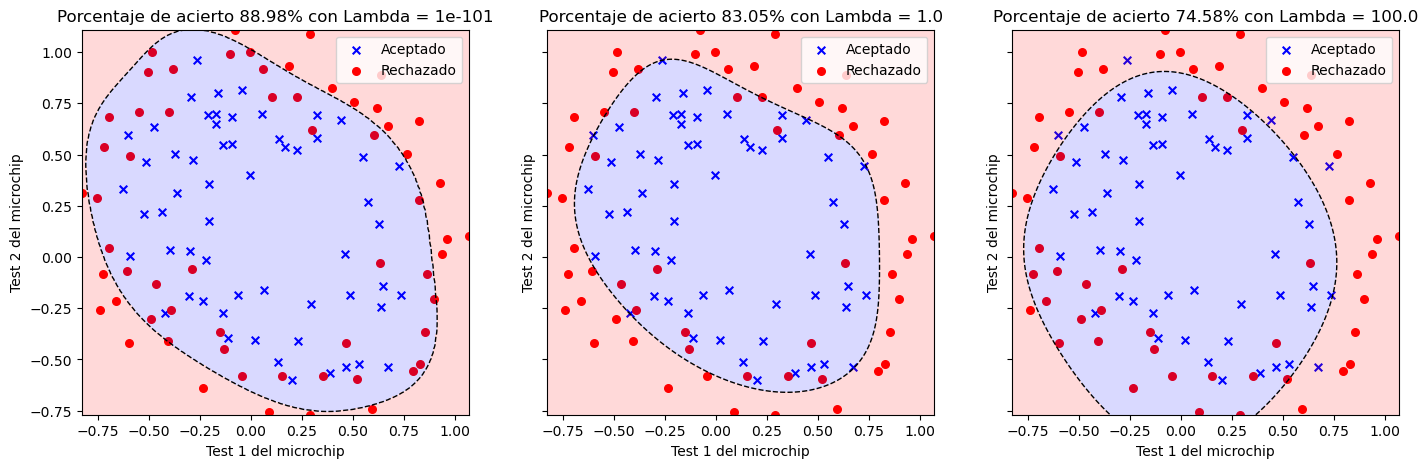

In [ ]:
# Se importa de la libreria scikit-learn de python (sklearn) el paquete correspondiente a la regresión lineal
from sklearn.linear_model import LogisticRegression

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(17, 5))

# Fronteras de decisión
# Lambda = 0.1e-100 : No se realiza regularización --> modelo muy flexible: sobre-entrenado
# Lambda = 1 : Parece que es un buen modelo: simple y preciso
# Lambda = 100 : Demasiada regularización: mucho bías

# Crea la variable valores_lambda
valores_lambda = [0.1e-100, 1.0, 100.0]

for i, valor_lambda in enumerate(valores_lambda):
    # solver : {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’}
    # Se incializa el modelo llamando al constructor de la regresión lineal
    # todos los parámetros se asignan a los valores mencionados anteriormente
    reg = LogisticRegression(penalty='l2', C=(1/valor_lambda), max_iter=400, solver='newton-cg')

    # Utiliza fit para ajustar el modelo a los datos XX con clases y (recuerda no pasar la columna de 1's)
    reg.fit(X_poly_norm[:, 1:], y.ravel())

    # Cálculo del porcentaje de acierto (recuerda no pasar la columna de 1's)
    coefs = reg.coef_
    indep = reg.intercept_

    thetas = np.concatenate((indep.ravel(),coefs.ravel()))

    probs, preds = predict(thetas, X_poly_norm)
    unique, counts = np.unique(np.where(preds == y.ravel(), True, False), return_counts=True)
    accuracy = (dict(zip(unique,counts)).get(True)/y.size)*100
    print(accuracy)

    # Gráfica que muestra los ejemplos, utiliza como último parámetro axes.flatten()[i] (le pasamos el manejador de la figura correspondiente)
    plot_data(X, y, "Test 1 del microchip", "Test 2 del microchip", "Aceptado", "Rechazado", ax=axes.flatten()[i])

    # Mostramos la frontera de decisión
    plot_logistic_regression_sklearn(reg, x1_lim, x2_lim, poly=poly, scaler=scaler, ax=axes.flatten()[i]);

    # Establecemos el título
    axes.flatten()[i].set_title(
        'Porcentaje de acierto {}% con Lambda = {}'.format(
            np.round(accuracy, decimals=2), valor_lambda
        )
    )


    # Mostrar los valores de theta para cada lambda "Los valores de theta para lambda = XX son [a, b, c...]"
    # <RELLENAR>

In [ ]:
test_nb((np.round(reg.coef_, 4)==[[ 0.0196,  0.0555, -0.1299, -0.0414, -0.0793, -0.0018, -0.0024,
        -0.023 , -0.0154, -0.1204, -0.0047, -0.0985, -0.0153, -0.0885,
        -0.0305, -0.0168, -0.0099, -0.0366, -0.0282, -0.0509, -0.0993,
         0.0051, -0.0979,  0.0098, -0.0864, -0.0067, -0.0827]]).all(),True, 'Valor de LogReg.coef_ con lambda = 100 incorrecto' )
test_nb((np.round(reg.intercept_, 4)==[-0.0581]).all(),True, 'Valor de LogReg.intercept_ con lambda = 100 incorrecto' )

✔️ Test passed.
✔️ Test passed.


## Práctica 4: Regresión Logística y Regularización - Apartado extra

Los ejercicios de este notebook permiten, si se completan perfectamente, alcanzar un 9 en esta práctica. Para alcanzar el 10, debe completarse el apartado extra en el notebook adicional.